In [1]:
!pip install jovian --upgrade

Requirement already up-to-date: jovian in /usr/local/lib/python3.6/dist-packages (0.2.15)


In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [3]:
project_name = 'cifar10-resnet'

In [4]:
dataset_url = "http://files.fast.ai/data/cifar10.tgz"
download_url(dataset_url, '.') #. to place it in the current directory

#extract
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path = './data')

Using downloaded and verified file: ./cifar10.tgz


In [5]:
data_dir = './data/cifar10'
print(os.listdir(data_dir))

['train', 'test', 'labels.txt']


In [6]:
classes = os.listdir(data_dir+ '/train')
print(classes)

['deer', 'airplane', 'horse', 'truck', 'frog', 'ship', 'cat', 'dog', 'bird', 'automobile']


In [7]:
#Data augmentation
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transform_train = tt.Compose([tt.RandomCrop(size = 32, padding = 4, padding_mode='reflect'),
                              tt.RandomHorizontalFlip(),
                              tt.ToTensor(),
                              tt.Normalize(*stats, inplace = True)])  #* is to unpack outer ()

transform_valid = tt.Compose([tt.ToTensor(),
                              tt.Normalize(*stats)])                              

In [8]:
#PyTorch datasets

train_ds = ImageFolder(data_dir +'/train', transform_train)
validation_ds = ImageFolder(data_dir + '/test', transform_valid)

In [9]:
#Batching 
batch_size = 400

train_loader = DataLoader(dataset = train_ds, batch_size=batch_size, shuffle = True, num_workers = 3, pin_memory= True)
validation_loader = DataLoader(dataset = validation_ds, batch_size=batch_size * 2, num_workers = 4, pin_memory=True)

#pin memory is for pushing the data loaded on CPU into the GPU quickly by allocating a page locked memory for it

In [10]:
from torchvision.utils import make_grid

def display_batch(dataloader):

  for images, labels in dataloader:
    fig, ax = plt.subplots(figsize = (14, 14))
    ax.set_xticks([]);
    ax.set_yticks([]);
    ax.imshow(make_grid(images[:64], nrow = 8).permute(1, 2, 0))  #to change (3, 32, 32) to (32, 32, 3)
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


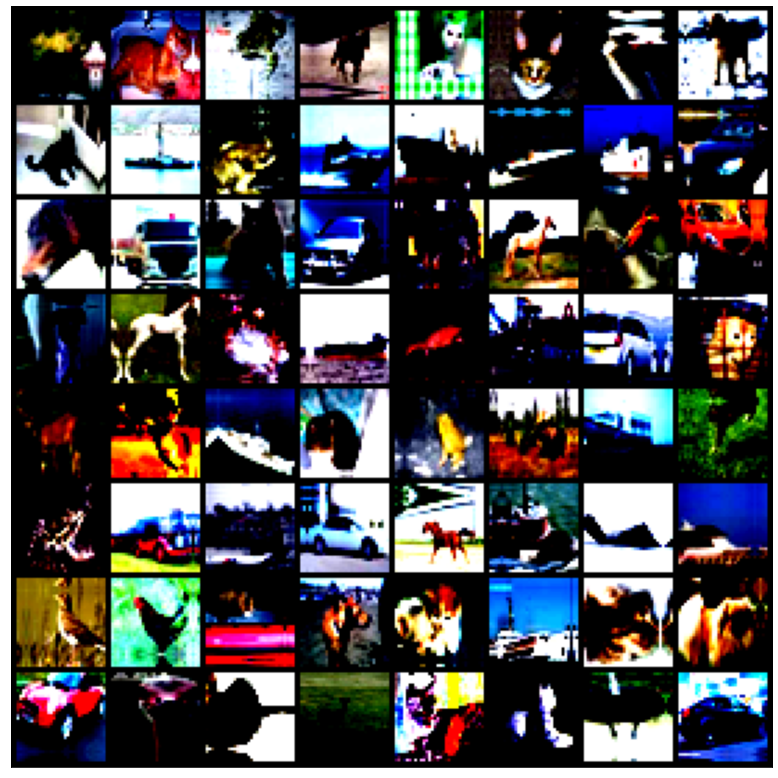

In [11]:
display_batch(train_loader) #color range is off due to normalization

In [12]:
#select the device to be used for torch

def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')

  else:
    return torch.device('cpu')

def to_device(data, device):   #this is to move the data to the default device
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]  #the data passed needs to be in tensor or complex array form
  return data.to(device, non_blocking = True)


class DeviceDataLoader():
  #this is to wrap a dataloader to a device to move thr data easily
  def __init__(self, loader, device):
    self.loader = loader
    self.device = device  #we do not need any inheritance but we need methods for counting the num of batches and to retrieve batches of data

  def __iter__(self):
    for data in self.loader:
      yield to_device(data, self.device)  #yield is used to return a sequence of values without having to store it in memory

  def __len__(self):
    return len(self.loader)    



In [13]:
device = get_default_device()
print(device)

cuda


In [14]:
#wrap the loaders to auto transfer data to the GPU

train_loader = DeviceDataLoader(train_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)

In [15]:
class SimpleResidualBlock(nn.Module):

  def __init__(self):
    super(SimpleResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(3, 3, 3, 1, 1)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(3, 3, 3, 1, 1)
    self.relu2 = nn.ReLU()

  def forward(self, x):
    out = self.conv1(x)
    out = self.relu1(out)
    out = self.conv2(out)
    out = self.relu2(out) 
    return out + x   

In [16]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_loader:
  out = simple_resnet(images)
  print(out.shape)
  break

del simple_resnet, images, labels
torch.cuda.empty_cache()  #release all the unused cache memory currently held by the cache allocator

torch.Size([400, 3, 32, 32])


In [17]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, 1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Base(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    outputs = self(images)
    loss = F.cross_entropy(outputs, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    outputs = self(images)
    loss = F.cross_entropy(outputs, labels)
    acc = accuracy(outputs, labels)
    return {'val_loss' : loss.detach(), 'val_acc' : acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss' : epoch_loss.item(), 'val_acc' : epoch_acc.item()} 

  def epoch_end(self, epoch, result):  #CHECK!!!!!!!!!!!!!!!!!!! (result is the output object)
      print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))


In [18]:
def conv_block(in_channels, out_channels, pool = False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True)]
  if pool:
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)  #unroll array elements

class ResNet9(Base):
  def __init__(self, in_channels, num_classes):
    super(ResNet9, self).__init__()   

    self.conv1 = conv_block(in_channels, 64)
    self.conv2 = conv_block(64, 128, pool = True)
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

    self.conv3 = conv_block(128, 256, pool = True)
    self.conv4 = conv_block(256, 512, pool = True)
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))    

    self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                    nn.Flatten(),
                                    nn.Linear(512, num_classes))

  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classifier(out)
    return out


In [19]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [20]:
#TRAINING

# 1. Learning rate is scheduled to slowly increase until 30% of the epochs, and then decreased
# 2. Weight decay to avoid exploding weights by adding a reg term to loss fn
# 3. Gradient clipping - These are the 3 modifs to be done to the FIT function

@torch.no_grad()

def evaluate(model, validation_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in validation_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']  

def fit_one_cycle(epochs, max_lr, model, train_loader, validation_loader,
                  weight_decay = 0., grad_clip = None, opt_func = torch.optim.SGD):

  torch.cuda.empty_cache()
  history = []

  #custom optimizer
  optimizer = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)
  #One Cycle LR Scheduler
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
                                                  max_lr = max_lr,
                                                  epochs = epochs,
                                                  steps_per_epoch = len(train_loader))

  for epoch in range(epochs):
    #training
    model.train(mode = True)
    train_losses = []   
    lrs = []

    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      #Grad clipping 
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()

      #lr - record and update
      lrs.append(get_lr(optimizer))
      scheduler.step()

    #Validation phase
    result = evaluate(model, validation_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)

  return history   


In [21]:
history = [evaluate(model, validation_loader)]
history

[{'val_acc': 0.0962500050663948, 'val_loss': 2.3133163452148438}]

In [22]:
#start training
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [23]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_loader, validation_loader,
                         weight_decay = weight_decay, grad_clip = grad_clip,
                         opt_func = opt_func)

Epoch [0], last_lr: 0.00393, train_loss: 1.2965, val_loss: 1.1758, val_acc: 0.6117
Epoch [1], last_lr: 0.00935, train_loss: 0.9956, val_loss: 0.9494, val_acc: 0.6788
Epoch [2], last_lr: 0.00972, train_loss: 0.8041, val_loss: 0.8072, val_acc: 0.7285
Epoch [3], last_lr: 0.00812, train_loss: 0.5969, val_loss: 0.7243, val_acc: 0.7605
Epoch [4], last_lr: 0.00556, train_loss: 0.4659, val_loss: 0.5015, val_acc: 0.8287
Epoch [5], last_lr: 0.00283, train_loss: 0.3534, val_loss: 0.3711, val_acc: 0.8762
Epoch [6], last_lr: 0.00077, train_loss: 0.2481, val_loss: 0.2920, val_acc: 0.9016
Epoch [7], last_lr: 0.00000, train_loss: 0.1886, val_loss: 0.2681, val_acc: 0.9093
CPU times: user 43.8 s, sys: 9.81 s, total: 53.6 s
Wall time: 3min 43s


In [24]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('Epoch')
  plt.ylabel('Validation Accuracy')
  plt.title('Accuracy vs Epochs');

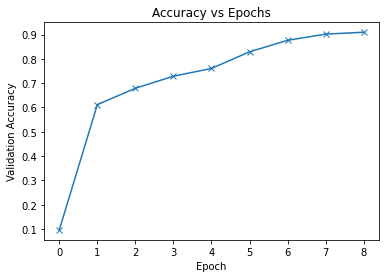

In [25]:
plot_accuracies(history)

In [26]:
def plot_losses(history):
  train_loss = [x.get('train_loss') for x in history]
  val_loss = [x['val_loss'] for x in history]
  plt.plot(train_loss, '-rx')
  plt.plot(val_loss, '-bx')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs Epochs');

In [27]:
history

[{'val_acc': 0.0962500050663948, 'val_loss': 2.3133163452148438},
 {'lrs': [0.0003999999999999993,
   0.000400264950421678,
   0.0004010597724372431,
   0.0004023843783015138,
   0.00040423862178329446,
   0.0004066222981815009,
   0.0004095351443477741,
   0.0004129768387155213,
   0.00041694700133542047,
   0.00042144519391736253,
   0.00042647091987883974,
   0.0004320236243997612,
   0.0004381026944837111,
   0.0004447074590256117,
   0.0004518371888858185,
   0.000459491096970608,
   0.0004676683383190751,
   0.00047636801019640754,
   0.0004855891521935562,
   0.0004953307463332387,
   0.0005055917171823444,
   0.0005163709319706434,
   0.0005276672007158388,
   0.00053947927635495,
   0.0005518058548819628,
   0.0005646455754918043,
   0.0005779970207305616,
   0.0005918587166519693,
   0.0006062291329801128,
   0.0006211066832783867,
   0.0006364897251246119,
   0.0006523765602923625,
   0.0006687654349384394,
   0.0006856545397964878,
   0.0007030420103767369,
   0.00072092592

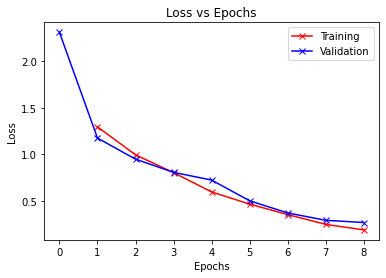

In [28]:
plot_losses(history)

In [29]:
import numpy as np
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

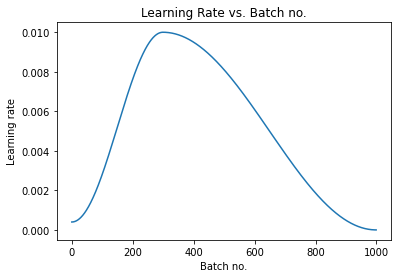

In [30]:
plot_lrs(history)